# **Quantum Frequency Resampling (QuFRes) - Demo Notebook**

This notebook demonstrates how to use QuFRes to perform quantum-based frequency resampling on a sample signal. We will go through the following steps:

1. Defining the signal

2. Choosing the resampling task and setting parameters

3. Initializing the simulation

4. Running the simulation

5. Examining the logbook

6. Recovering the output

In the next cell, we simple import the necessary tools and define some useful parameters for plotting results later on.

In [1]:
import numpy as np #array-handling
import matplotlib.pyplot as plt #plotting inputs and results
from resample_sim import * # simulation class


plt.rcParams['text.usetex'] = True #optional: Tex handling in plots
plt.rcParams.update({'font.size': 18})


## **The signal**
To begin, we define a sample signal that we wish to process. In pratical applications, the input could be any structured data, ranging from a time-series (e.g., audio waveform, sensor data, stock market trends), a digital image, a voltage train or even experimental data points.

**In this demo, we generete a syntethic one-dimensional signal for simplicity**. The signal is then visualized to provide an intuitive understanding of its structure before applying quantum resampling.

Notice that, currently, the code allows only for hypercubic (i.e. square) arrays.

In [2]:
t = np.linspace(0,2,512)
c = 8   #bit-depth
L = 2**c    
signal = np.sinc(5*(t-1))+1   #unit-shifted sinc
signal = np.round(signal/signal.max()*L)    #quantization of sample values

Specifically, we opt for a truncated sinc function, rescaled (by 5) and unit-shifted both in the x (+1) and y(-1) axes. 

The signal is sampled (e.g. in time) in the [0,2]s interval at a 256 Hz rate. Optionally, we can decide to quantize input samples (the range and depth of the quantization is controlled here through `c`, the bit-depth).


[]

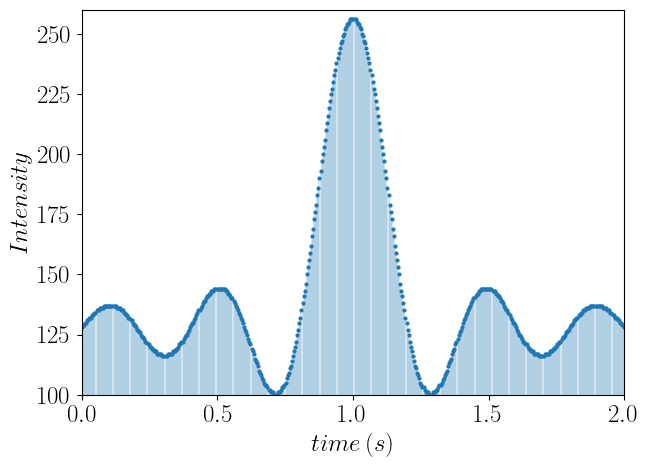

In [3]:
fig, ax = plt.subplots(figsize=(7, 5))

# Linea continua della sinc
ax.plot(t, signal, lw=0,marker='o',markersize=2)

# Linee verticali per i punti campionati
ax.vlines(t, signal.min(), signal, linewidth=0.3,alpha=0.9)

# Personalizzazioni del grafico principale
ax.set_xlabel(r'$time\,(s)$')
ax.set_ylabel(r'$Intensity$')
ax.set_ylim(100,260)
ax.set_xlim(-.0,2.0)

plt.plot()

The number of qubits required to encode such a signal can be promptly computed by invoking the `get_numQubits` from the `encoding` module


In [4]:
from encoding import get_numQubits

input_size = get_numQubits(signal)
print(f'We need an {input_size}-qubits register to encode the input signal')

We need an 9-qubits register to encode the input signal


## **Instantating the simulation**

We now move on to initialize a fresh simulation of our quantum resampling algorithms, as implemented by the `Resample_Sim` class.
Class instances must be built by providing the input signal, the task to perform, and a set of parameters specific to the chosen algorithm. Eventually,
the simulation module allows to decide whether or not to subdivide the input into non-overlapping patches for parallel processing (in this case, the patch shape must be provided).

The resampling task determines the quantum algorithm we want to apply to our signal.
The currently implemented tasks are:
1. Downsampling (reduces the sampling rate by discarding qubits)
    - 1D -> ` "downsample_1D"`
    - 2D-> ` "downsample_2D"`
    - MD-> ` "downsample_MD"`
2. Upsampling (MD) (increases the sampling rate by appending new qubits) -> ` "upsample"`

Each routine has a specific set of parameters that must be passed to the class constructor as a tuple. 1D and 2D Downsampling require the number of qubits to be discarded (per axis) and (optionally) whether or not to add Hadamard gates at the beginning and end of the respective circuits. Conversely, MD Downsampling (Upsampling) requires also the dimensionality, i.e. the number of axes, of the signal, to be appended before the number of qubits to be discarded (added).


For this demo, we will consider downsampling from  9 (512) to 8 qubits (256 samples). 

In [5]:
task = 'downsample_1D'

num_dis = 1
useHadamards = True
params = (num_dis,useHadamards)


With the signal and resampling parameters defined, we can properly initialize the QuFRes simulation.

In [6]:
simulation = Resampling_Sim(signal,task,params,patch_shape=None)

We can access the encoded signal, its norm, and the review the task at hand through specific class attributes. For instance:

In [7]:
simulation.norms

72350.0

returns the norm of the input signal, which will be used down the line for output retrieval

## **Running the simulation**

We are now free to run the resampling simulation. Since output retrieval requires multiple repetitions (shots) of the algorithm, we can specifiy, for each run, the amount of iterations to perform

In [8]:
shots = 1000

simulation.run(shots)

Simulation completed.


True

As we can see, the required shots have been successfully collected. The preliminary results of each run are collected in a logbook, which collects info on the task at hand, whether or not the signal is patched, the occurence frequency computed from the available statistics, and the overall number of shots performed.


In [9]:
simulation.logbook.keys()

dict_keys(['task', 'patches', 'frequencies', 'shots'])

The logbook simplifies result tracking and enables adjustments for future experiments. In particular, the same simulation can be re-run multiple times to gather additional statistical data. New measurement results are added to existing ones, up to a proper normalization. This iterative approach allows users to fine-tune output retrieval, actively monitoring noise levels and determining whether further measurements are necessary for improved accuracy.
For example, a quick plot shows the above number of shots was not sufficient for a full output reconstruction

Signal successfully reconstructed!


[]

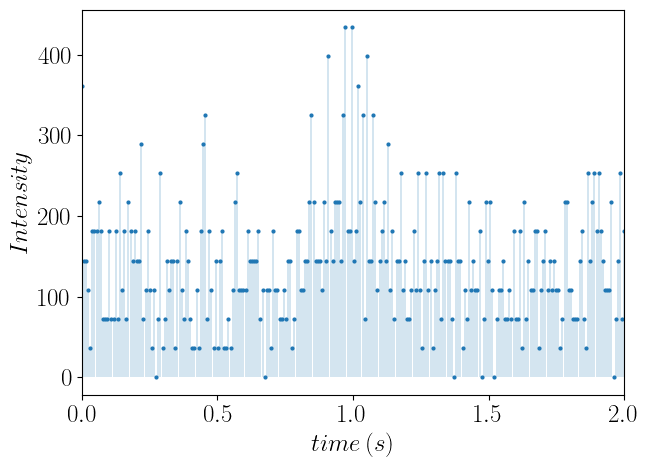

In [10]:
simulation.reconstruct()

partial_output = simulation.output

downsampled_t = np.linspace(0,2,256)

p_fig, p_ax = plt.subplots(figsize=(7, 5))

p_ax.plot(downsampled_t, partial_output, lw=0,marker='o',markersize=2)

p_ax.vlines(downsampled_t, partial_output.min(), partial_output, linewidth=0.3,alpha=0.9)

p_ax.set_xlabel(r'$time\,(s)$')
p_ax.set_ylabel(r'$Intensity$')
p_ax.set_xlim(-.0,2.0)

plt.plot()

We thus collect more shots, and finally reconstruct the correct output

In [11]:
simulation.run(shots**2)

print('total executions:',simulation.logbook['shots'])

Simulation completed.
total executions: 1001000


In [12]:
simulation.reconstruct()

Signal successfully reconstructed!


True

[]

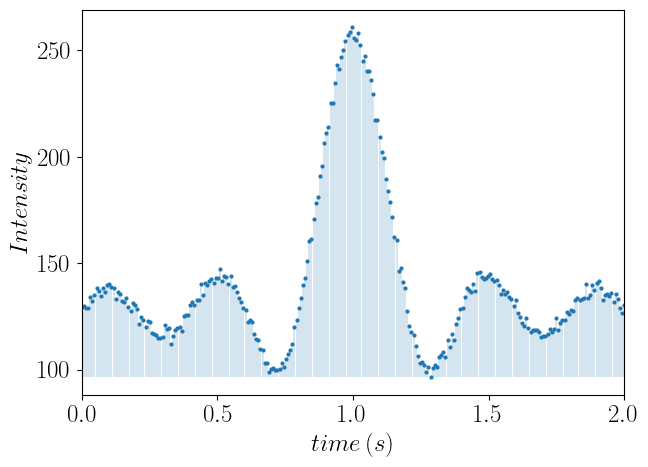

In [13]:
output = simulation.output

out_fig, out_ax = plt.subplots(figsize=(7, 5))

# Linea continua della sinc
out_ax.plot(downsampled_t, output, lw=0,marker='o',markersize=2)

# Linee verticali per i punti campionati
out_ax.vlines(downsampled_t, output.min(), output, linewidth=0.3,alpha=0.9)

# Personalizzazioni del grafico principale
out_ax.set_xlabel(r'$time\,(s)$')
out_ax.set_ylabel(r'$Intensity$')
#out_ax.set_ylim(100,260)
out_ax.set_xlim(-.0,2.0)

plt.plot()

## **Optional: Patching the signal**

As a final, optional, consideration, we show the possibility of patching our input signal. 

All simulation parameters are the same as above, although we further provide the shape of the desired patches. Notice that this shape, and thus the number, of the patches depends on the signal at hand: since the same amount of qubits will be discarded from each patch, one must account for more intense aliasing than the patch-less approach. 

In this demo, we split the signal into two patches, each with 256 samples.

In [14]:
patch_shape = (256,)

patched_simulation = Resampling_Sim(signal,task=task,params=params,patch_shape=patch_shape)


(2, 256)


In patched-based mode, states and norms corresponding to each past are collected into an array, and passed in parallel to the simulator:

In [15]:
patched_simulation.norms

array([36175., 36175.])

In [16]:
patched_simulation.run(100000)
patched_simulation.reconstruct()

Simulation completed.
Signal successfully reconstructed!


True

The conversion from patches to full output is carried out automatically by the `reconstruct()` method. 
We show here the downsampled signal after 100,000 iterations (per patch)

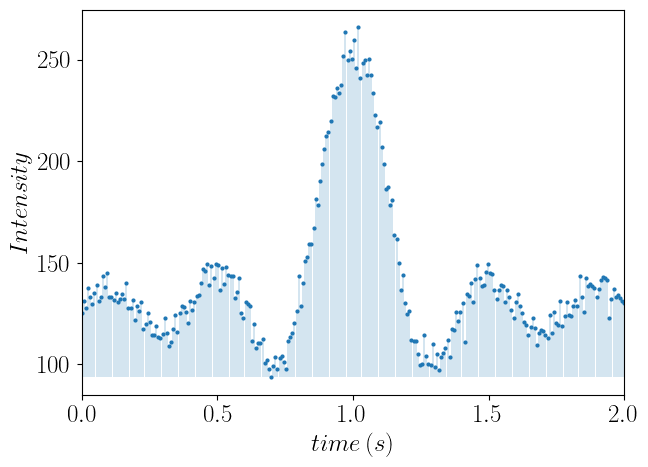

In [18]:
patched_output = patched_simulation.output



new_fig, new_ax = plt.subplots(figsize=(7, 5))

# Linea continua della sinc
new_ax.plot(downsampled_t, patched_output, lw=0,marker='o',markersize=2)

# Linee verticali per i punti campionati
new_ax.vlines(downsampled_t, patched_output.min(), patched_output, linewidth=0.3,alpha=0.9)

# Personalizzazioni del grafico principale
new_ax.set_xlabel(r'$time\,(s)$')
new_ax.set_ylabel(r'$Intensity$')
#out_ax.set_ylim(100,260)
new_ax.set_xlim(-.0,2.0)

plt.show()

## This concludes our demo!

Feel free to contact us for further info on our algorithms, and to use them for your signal-processign tasks. 
